In [1]:
!pip install keras-tuner


Trial 20 Complete [00h 04m 22s]
val_accuracy: 0.8449917435646057

Best val_accuracy So Far: 0.8468542993068695
Total elapsed time: 02h 19m 33s


/home/angadjeet22071/miniconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6444 - loss: 8.9160 - val_accuracy: 0.7918 - val_loss: 6.9844 - learning_rate: 2.4517e-04
Epoch 2/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7311 - loss: 6.6286 - val_accuracy: 0.8104 - val_loss: 5.3849 - learning_rate: 2.4517e-04
Epoch 3/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7596 - loss: 5.1278 - val_accuracy: 0.8216 - val_loss: 4.2429 - learning_rate: 2.4517e-04
Epoch 4/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8102 - loss: 4.0040 - val_accuracy: 0.8303 - val_loss: 3.4013 - learning_rate: 2.4517e-04
Epoch 5/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8192 - loss: 3.2041 - val_accuracy: 0.8295 - val_loss: 2.7705 - learning_rate: 2.4517e-04
Epoch 6/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8281 - loss: 2.5930 - val_accuracy: 0.8336 - val_loss: 2.2627 - learning_rate: 2.4517e-04
Epoch 7/300
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - ac

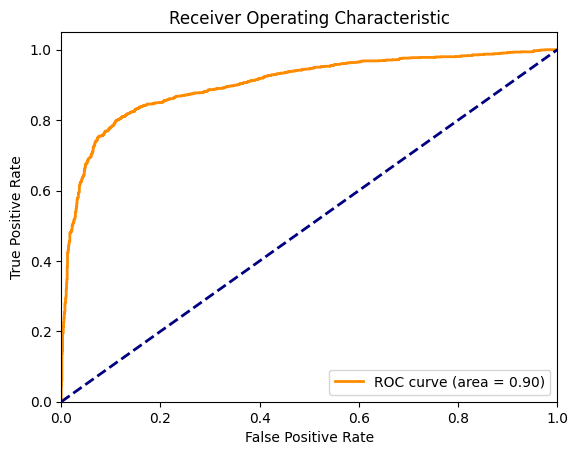

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, roc_curve, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from imblearn.over_sampling import SMOTE
from kerastuner.tuners import BayesianOptimization

print("Loading libraries and starting...")

# Load the dataset
df = pd.read_csv('merged_data_clean.csv')
print("Initial dataset loaded")
print(df.head(10))
print("Dataset shape:", df.shape)

# Store categorical columns and drop them
categorical_columns = ['SMILES', 'Source']
df = df.drop(columns=categorical_columns)
print("Dataset after dropping categorical columns")
print(df.head(10))

Y = df['Toxicity']
X_pca_df = pd.read_csv('X_pca_clean.csv')
print("PCA DataFrame shape:", X_pca_df.shape)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_pca_df, Y)
print("Data after applying SMOTE")
print("X_resampled shape:", X_resampled.shape)
print("Y_resampled distribution:", np.bincount(Y_resampled))

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, shuffle=True, stratify=Y_resampled)
print("Data split into train and test sets")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check GPU availability
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Tune the number of units in each layer
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(LeakyReLU(alpha=0.01))
        model.add(LayerNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.3, max_value=0.5, step=0.05)))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the tuner with Bayesian Optimization
tuner = BayesianOptimization(build_model, 
                             objective='val_accuracy', 
                             max_trials=20, 
                             executions_per_trial=2, 
                             directory='tuner_dir', 
                             project_name='hyperparameter_tuning_bayes')

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Search for the best hyperparameter configuration
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, Y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
print("Evaluating the model on test data...")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Make predictions
print("Making predictions on test data...")
Y_pred_prob = model.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype(int)

# Additional metrics and evaluation
print("Generating classification report and confusion matrix...")
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(f'ROC AUC: {roc_auc_score(Y_test, Y_pred_prob)}')
print(f'Precision: {precision_score(Y_test, Y_pred)}')
print(f'Recall: {recall_score(Y_test, Y_pred)}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(Y_test, Y_pred)}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(Y_test, Y_pred_prob))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [3]:
# Calculate additional metrics
f1 = f1_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
cr = classification_report(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
mcc = matthews_corrcoef(Y_test, Y_pred)

print("F1 Score: ", f1)
print("Confusion Matrix: \n", cm)
print("Classification Report: \n", cr)
print("ROC AUC Score: ", roc_auc)
print("Precision: ", precision)
print("Recall: ", recall)
print("Matthews Correlation Coefficient: ", mcc)
print("accuracy_score: ", accuracy_score(Y_test, Y_pred))

F1 Score:  0.8308771929824561
Confusion Matrix: 
 [[1354  156]
 [ 326 1184]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      1510
         1.0       0.88      0.78      0.83      1510

    accuracy                           0.84      3020
   macro avg       0.84      0.84      0.84      3020
weighted avg       0.84      0.84      0.84      3020

ROC AUC Score:  0.9025735713345905
Precision:  0.8835820895522388
Recall:  0.7841059602649006
Matthews Correlation Coefficient:  0.6851506508475252
accuracy_score:  0.8403973509933775


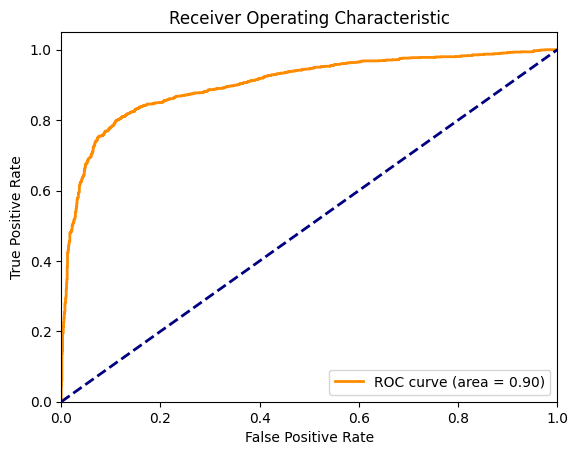

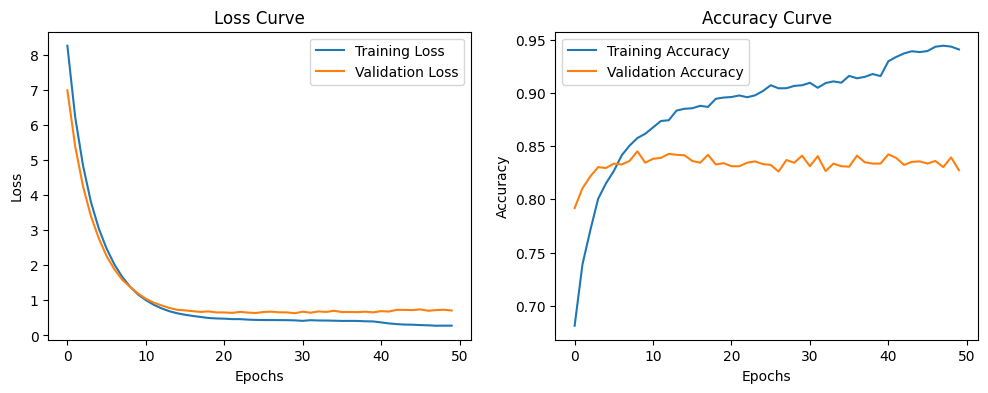

In [4]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()